In [81]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Rectangle

import torch
import os

# preprocess.py contains the function to load and preprocess the ice velocity data
from real_preprocess import load_and_preprocess_ice_velocity_data, create_flux_df_for_region, visualise_flux, visualise_flux_train_test_split, find_very_close_points, df_to_tensor

# Load data sets

In [82]:
### ICE THICKNESS DATA ###
# Bedmap 1 + 2 + 3 
path_to_bedmap_data_folder = "/home/kim/data/bedmap_raw_data_test"
path_bedmap123_byrd = os.path.join(path_to_bedmap_data_folder, "bedmap123_byrd_catchment.csv")
thickness_points = pd.read_csv(path_bedmap123_byrd)

### ICE VELOCITY DATA ###
# NSIDC MEaSUREs Antarctic Ice Velocity Map
# NOTE: The coordinates in load_and_preprocess_ice_velocity_data() need to be large enough to not produce NaN in the interpolation
ice_vel_file_path = '/home/kim/data/nsidc/antarctica_ice_velocity_450m_v2.nc'
# Function to load and preprocess the ice velocity data as xarray
velocity_grid = load_and_preprocess_ice_velocity_data(ice_vel_file_path)

# Check
print(f"Check number of rows Nan thickness:", thickness_points["t"].isna().sum())
print(f"Check number of rows Nan velocity:", np.isnan(velocity_grid.VX.values).sum())

Check number of rows Nan thickness: 0
Check number of rows Nan velocity: 0


## Load meta data for all of Antarctica (incl. firn correction notes)

In [83]:
meta = pd.read_csv("/home/kim/data/bedmap_raw_data_test/bedmap123_metadata.csv")

print(meta.BM_version.value_counts())
print()
print(meta.platform.value_counts())
print()
print(meta.firn.value_counts())

BM3    84
BM2    66
BM1     1
Name: BM_version, dtype: int64

airborne radar.                        114
ground-based radar.                     33
seismic.                                 3
airborne radar, gravity and seismic      1
Name: platform, dtype: int64

0 (m)        92
10 (m)       28
-9999 (m)    25
4.7 (m)       1
5 (m)         1
8.8 (m)       1
2 (m)         1
6.5 (m)       1
8 (m)         1
Name: firn, dtype: int64


# Firn adjustments

In [ ]:
# Extract float
meta["firn_correction"] = meta.firn.str.extract(r"([-+]?\d*\.?\d+)").astype(float)
# Replace -9999 with 0.0 (We assume this means "zero" adjustment applied so far.)
meta["firn_correction"] = meta["firn_correction"].replace(-9999, 0.0)
# Calculate remaining delta (we correct all data to have a firn correction of 10)
# t_corrected = t_observed - 10

UNIVERSAL_FIRN_CORRECTION = 10.0
meta["firn_correction_delta"] = meta["firn_correction"] - UNIVERSAL_FIRN_CORRECTION

In [85]:
# Create lookup dictionary from meta
firn_delta_lookup = dict(zip(meta["source"], meta["firn_correction_delta"]))

# Add the correction delta to the thickness points
# NOTE: Overwrite
thickness_points["t"] = (
    thickness_points["t"] + thickness_points["source"].map(firn_delta_lookup)
)

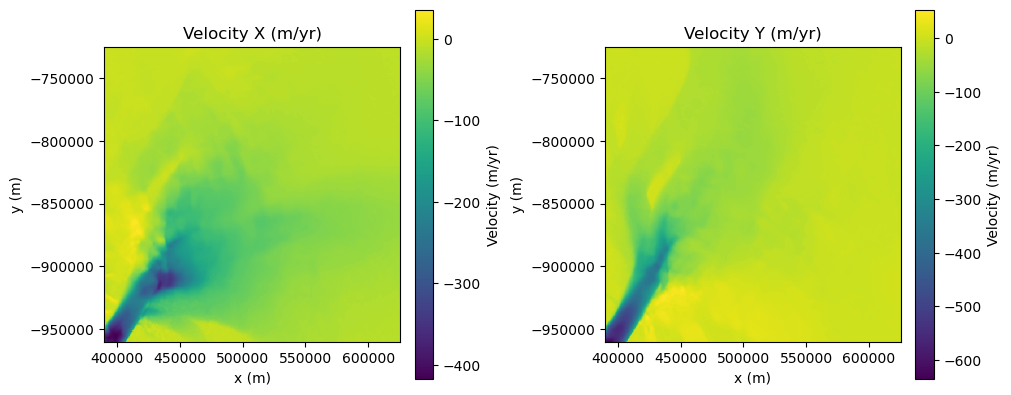

In [86]:
fig, axs = plt.subplots(1, 2, figsize = (10, 4), constrained_layout = True)

# VX
c1 = axs[0].pcolormesh(
    velocity_grid.x.values, 
    velocity_grid.y.values, 
    velocity_grid.VX.values, 
    cmap = 'viridis'
)
axs[0].set_title('Velocity X (m/yr)')
axs[0].set_aspect('equal')
axs[0].set_xlabel('x (m)')
axs[0].set_ylabel('y (m)')
fig.colorbar(c1, ax = axs[0], label = 'Velocity (m/yr)')

# VY
c2 = axs[1].pcolormesh(
    velocity_grid.x.values, 
    velocity_grid.y.values, 
    velocity_grid.VY.values, 
    cmap = 'viridis'
)
axs[1].set_title('Velocity Y (m/yr)')
axs[1].set_aspect('equal')
axs[1].set_xlabel('x (m)')
axs[1].set_ylabel('y (m)')
fig.colorbar(c2, ax = axs[1], label = 'Velocity (m/yr)')

plt.show()

In [87]:
print(f"Velocity extremes in Y directions:", velocity_grid.VY.max().item(), velocity_grid.VY.min().item())
print(f"Velocity extremes in X direction:", velocity_grid.VX.max().item(), velocity_grid.VX.min().item())

Velocity extremes in Y directions: 53.02280807495117 -635.0150756835938
Velocity extremes in X direction: 36.05989074707031 -417.02191162109375


## Get overview of ice thickness data

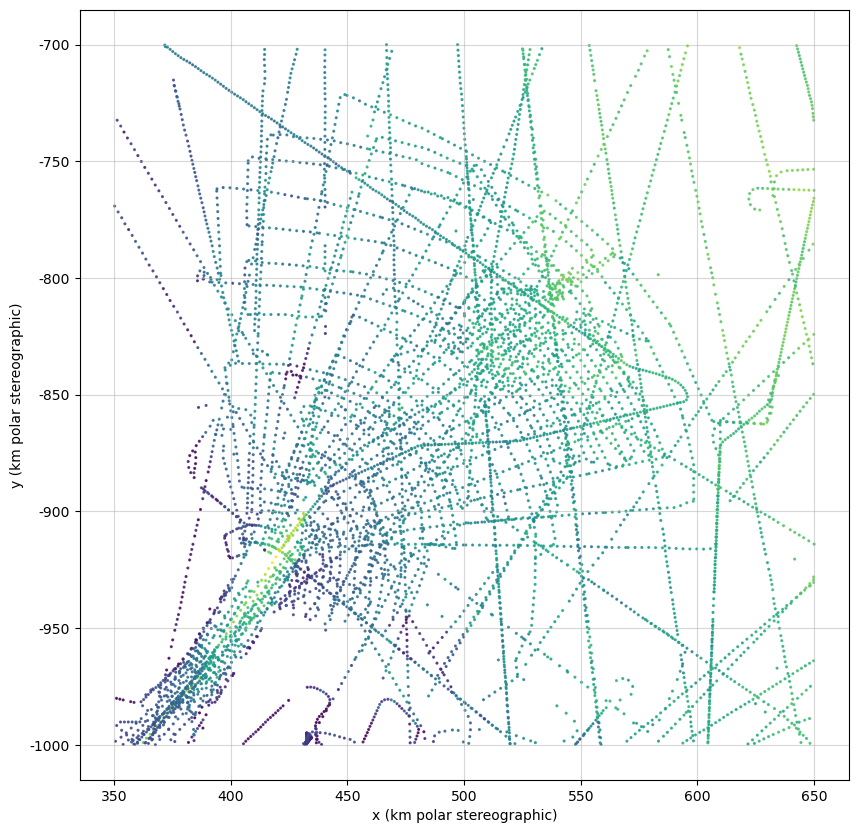

In [88]:
reduce_rate = 100
# sub-ample every 100th point to reduce the number of points for plotting
thickness_points_ss = thickness_points[::reduce_rate]

fig, ax = plt.subplots(figsize = (10, 10))
ax.scatter(thickness_points_ss['x'], thickness_points_ss['y'], c = thickness_points_ss['t'], s = 1.5, alpha = 0.8, cmap = 'viridis')

# Set both axes to use scientific notation with base 10^3
formatter = ticker.FuncFormatter(lambda x, pos: f'{x*1e-3:.0f}')
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)

# Optional: label axes to clarify units
ax.set_xlabel("x (km polar stereographic)")
ax.set_ylabel("y (km polar stereographic)")

ax.set_aspect('equal')
ax.grid(True, alpha = 0.5)  # Show gridlines

## Visualise by survey

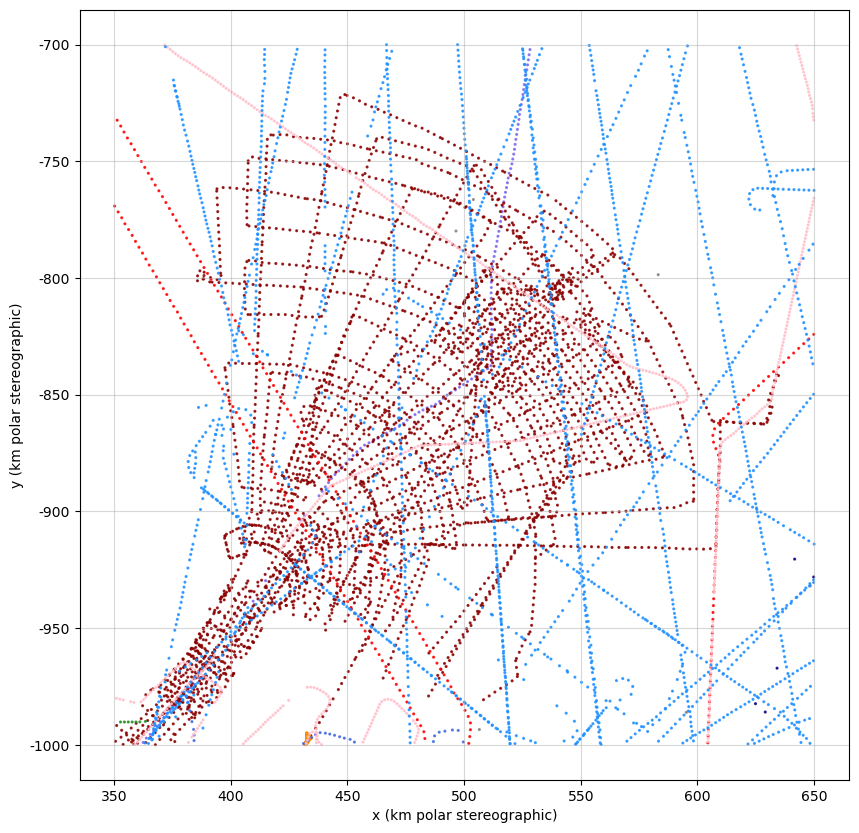

In [89]:
source_color_dict = {
    'BEDMAP1_1966-2000_AIR_BM1.csv': "gray",
    'NASA_2011_ICEBRIDGE_AIR_BM2.csv': "darkred",
    'NASA_2013_ICEBRIDGE_AIR_BM3.csv': "red",
    'NASA_2017_ICEBRIDGE_AIR_BM3.csv': "pink",
    'UTIG_1999_SOAR-LVS-WLK_AIR_BM2.csv': "navy",
    'UTIG_2004_AGASEA_AIR_BM2.csv': "mediumblue",
    'UTIG_2009_Darwin-Hatherton_AIR_BM3.csv': "royalblue",
    'UTIG_2010_ICECAP_AIR_BM3.csv': "dodgerblue",
    'BAS_2007_AGAP_AIR_BM2.csv': "mediumslateblue",
    'UCANTERBURY_2008_Darwin-Hatherton_GRN_BM2.csv': "darkorange",
    'LDEO_2015_ROSETTA_AIR_BM3.csv': "forestgreen"}

fig, ax = plt.subplots(figsize = (10, 10))
ax.scatter(
    thickness_points_ss['x'], 
    thickness_points_ss['y'],  
    s = 1.5, 
    alpha = 0.8, 
    color = thickness_points_ss['source'].map(source_color_dict))

# Set both axes to use scientific notation with base 10^3
formatter = ticker.FuncFormatter(lambda x, pos: f'{x*1e-3:.0f}')
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)

# Optional: label axes to clarify units
ax.set_xlabel("x (km polar stereographic)")
ax.set_ylabel("y (km polar stereographic)")

ax.set_aspect('equal')
ax.grid(True, alpha = 0.5)  # Show gridlines

# Define regions for experiments

In [90]:
corners_regions = pd.DataFrame([
    # define full region again
    {"name": "region_Byrd", "x_min": 350 * 1000, "x_max": 650 * 1000, "y_min": -1000 * 1000, "y_max": -700 * 1000},
    # A - 70 x 70 region with regular flight lines
    {"name": "region_upper_byrd", "x_min": 400 * 1000, "x_max": 470 * 1000, "y_min": -800 * 1000, "y_max": -730 * 1000},
    # B - 70 x 70 km region 
    {"name": "region_mid_byrd", "x_min": 395 * 1000, "x_max": 465 * 1000, "y_min": -870 * 1000, "y_max": -800 * 1000},
    # C - 30 x 30 km region
    {"name": "region_lower_byrd", "x_min": 420 * 1000, "x_max": 450 * 1000, "y_min": -910 * 1000, "y_max": -880 * 1000}, 
])

# ToDo: save

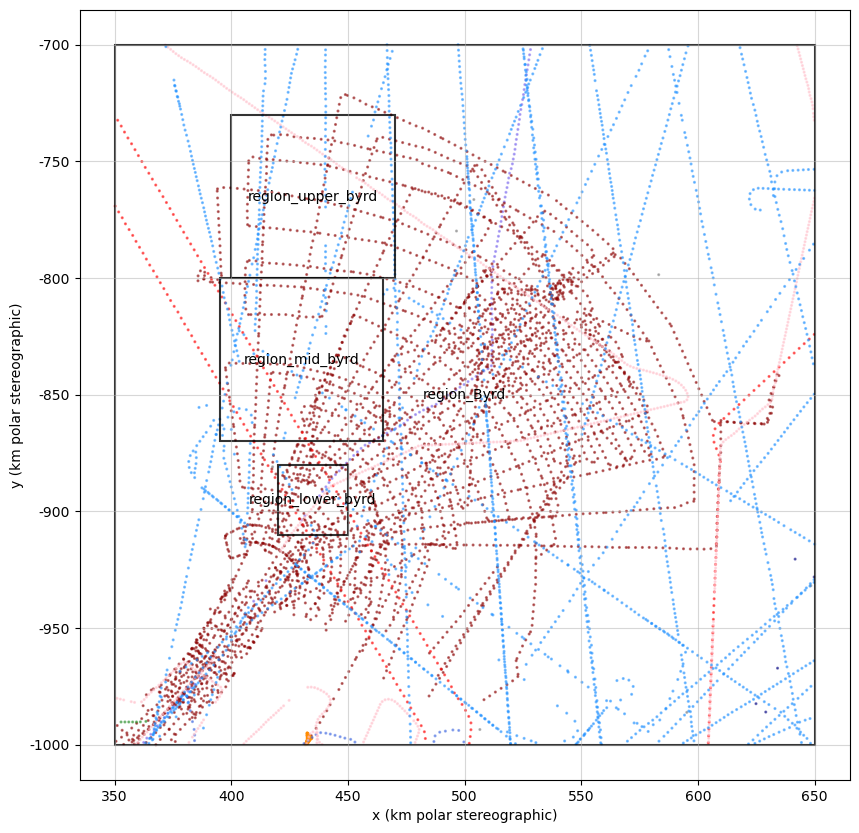

In [91]:
# Setup the figure
fig, ax = plt.subplots(figsize=(10, 10))

# Scatter plot
ax.scatter(
    thickness_points_ss['x'], 
    thickness_points_ss['y'],  
    s = 1.5, 
    alpha = 0.5, 
    color = thickness_points_ss['source'].map(source_color_dict)
)

# Set axes to scientific notation (in km)
formatter = ticker.FuncFormatter(lambda x, pos: f'{x*1e-3:.0f}')
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)

# Labels
ax.set_xlabel("x (km polar stereographic)")
ax.set_ylabel("y (km polar stereographic)")

# Grid and aspect
ax.set_aspect('equal')
ax.grid(True, alpha=0.5)

# Define and add rectangles
for _, region in corners_regions.iterrows():
    width = region["x_max"] - region["x_min"]
    height = region["y_max"] - region["y_min"]
    rect = Rectangle(
        (region["x_min"], region["y_min"]),
        width,
        height,
        linewidth = 1.5,
        edgecolor = "black",
        facecolor = "none",
        alpha = 0.8,
        linestyle = "-",
        label = region["name"]
    )
    ax.add_patch(rect)
    # Optionally label the region in the middle
    ax.text(
        region["x_min"] + width / 2,
        region["y_min"] + height / 2,
        region["name"],
        color = "black",
        fontsize = 10,
        ha = "center",
        va = "center"
    )

plt.show()

# Upper Byrd

process by flight lines

## Upper Byrd specs
- subsample_rate = 50
- threshold = 250 m
- region_flux_scale = 15 * 1000 m

Subsampled data shape: (757, 18)
Minimum pairwise distance found among points in dataset (in m): 51.392
Number of rows to remove: 9
Rows to remove: {388, 617, 618, 11, 532, 597, 536, 474, 510}


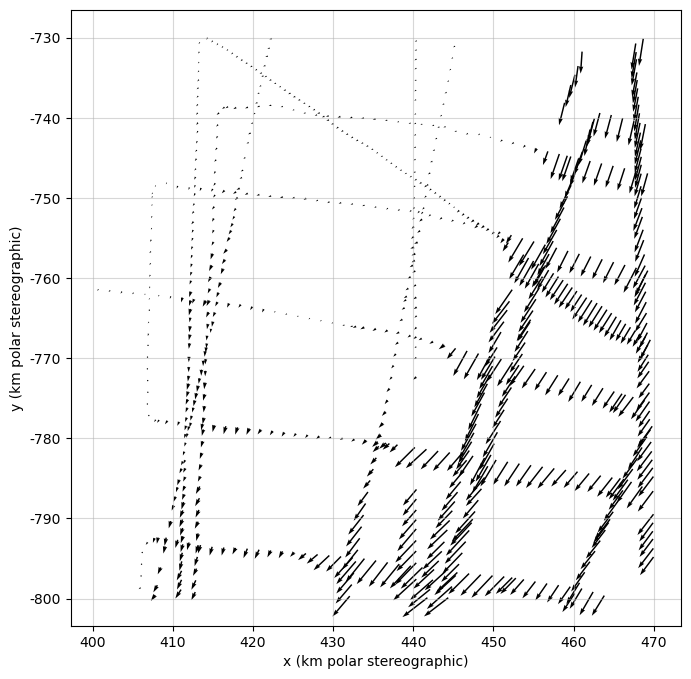

In [92]:
# Define region
region_name = "region_upper_byrd"

# Generate DataFrame
region_df = create_flux_df_for_region(
    region_name, thickness_points, velocity_grid, corners_regions, subsample_rate = 50)

# Remove NaN's if needed
# print(region_df.isna().sum())
# region_df = region_df.dropna()

# Visualise with color corresponing to survey/source
# visualise_flux(region_df, source_color = True)

# Remove very close points
removal_indices = find_very_close_points(region_df, threshold = 250)

region_df_mindist = region_df.drop(removal_indices).reset_index(drop = True) # NOTE: reset indices is important
# Last value is a clear outlier. Remove.
region_df_mindist = region_df_mindist.drop(747).reset_index(drop = True)
# Remove first value from BM0 because it so so isolated.
region_df_mindist = region_df_mindist.drop(0).reset_index(drop = True)

# Visualise
visualise_flux(region_df_mindist)

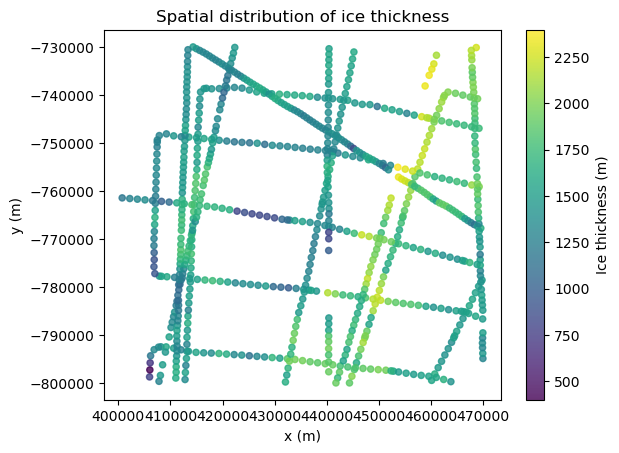

In [93]:
sc = plt.scatter(
    region_df_mindist['x'], 
    region_df_mindist['y'], 
    c = region_df_mindist['t'], 
    s = 20.0, 
    alpha = 0.8, 
    cmap = 'viridis'
)

plt.colorbar(sc, label = 'Ice thickness (m)')  # Optional label
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("Spatial distribution of ice thickness")
plt.show()

## Upper Byrd train-test-split

The dataset contains 746 points.


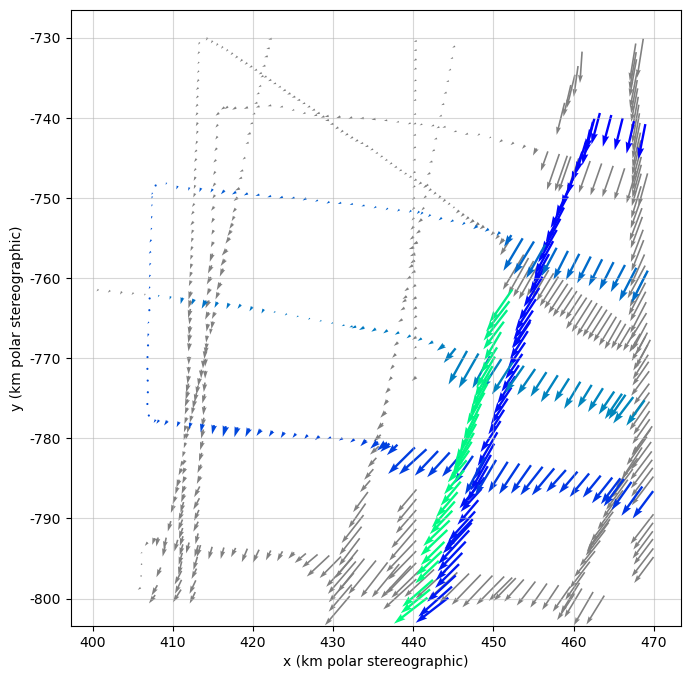

In [94]:
test_indices = list(list(range(100, 152)) # vertical from right line
                    + list(range(199, 312)) # horizontal C shape
                    + list(range(317, 363)) # left corner
                    + list(range(562, 593)) # vertical parallel to first line
                    )
        
visualise_flux_train_test_split(region_df_mindist, test_indices, usecmap = "winter") # "turbo" "winter"

In [95]:
upper_meta = meta[meta["source"].isin(region_df_mindist["source"].unique())]
upper_meta

,source,BM_version,platform,firn,firn_correction,firn_correction_delta
24,NASA_2011_ICEBRIDGE_AIR_BM2.csv,BM2,airborne radar.,0 (m),0.0,-10.0
117,NASA_2017_ICEBRIDGE_AIR_BM3.csv,BM3,airborne radar.,0 (m),0.0,-10.0
150,UTIG_2010_ICECAP_AIR_BM3.csv,BM3,airborne radar.,0 (m),0.0,-10.0


## Upper Byrd scaling 

In [ ]:
print(region_df_mindist["xflux"].mean())
print(region_df_mindist["yflux"].mean())

region_flux_scale = 15_000

-16743.164620439777
-25775.95852009872


In [97]:
# Get remaining train indices
all_indices = list(range(region_df_mindist.shape[0]))
print(f"The dataset contains {len(all_indices)} points.")
train_indices = list(set(all_indices) - set(test_indices))

# extract boundries of the region
x_min, x_max, y_min, y_max = corners_regions[corners_regions["name"] == region_name].loc[:, ["x_min", "x_max", "y_min", "y_max"]].values[0].tolist()

region_train_tensor = df_to_tensor(
    region_df_mindist.iloc[train_indices], x_min, x_max, y_min, y_max, region_flux_scale)
region_test_tensor = df_to_tensor(
    region_df_mindist.iloc[test_indices], x_min, x_max, y_min, y_max, region_flux_scale)

print(f"Train tensor shape: {region_train_tensor.shape}")
print(f"Test tensor shape: {region_test_tensor.shape}")

### STATS ###
# Compute mean and standard deviation along the samples (dim=1)
means_train = region_train_tensor.mean(dim = 1)
stds_train = region_train_tensor.std(dim = 1)

means_test = region_test_tensor.mean(dim = 1)
stds_test = region_test_tensor.std(dim = 1)

# Define column names
column_names = [
    "x",
    "y",
    "surface elevation [km] (s)",
    "ice flux x [m^2/year] (u)", # m^3/m/year
    "ice flux y [m^2/year] (v)",
    "ice flux error x (u_err)",
    "ice flux error y (v_err)",
    "source age"
]

# Print neatly
print()
print("TRAIN Column Statistics (Mean ± Std):")
for i, name in enumerate(column_names):
    print(f"{name:27s}: {means_train[i]:.3f} ± {stds_train[i]:.3f}")

# Print neatly
print()
print("TEST Column Statistics (Mean ± Std):")
for i, name in enumerate(column_names):
    print(f"{name:27s}: {means_test[i]:.3f} ± {stds_test[i]:.3f}")

The dataset contains 746 points.
Train tensor shape: torch.Size([8, 504])
Test tensor shape: torch.Size([8, 242])

TRAIN Column Statistics (Mean ± Std):
x                          : 0.504 ± 0.296
y                          : 0.530 ± 0.307
surface elevation [km] (s) : 2.028 ± 0.129
ice flux x [m^2/year] (u)  : -0.918 ± 0.920
ice flux y [m^2/year] (v)  : -1.470 ± 1.426
ice flux error x (u_err)   : 0.033 ± 0.017
ice flux error y (v_err)   : 0.044 ± 0.026
source age                 : 5.363 ± 2.527

TEST Column Statistics (Mean ± Std):
x                          : 0.581 ± 0.267
y                          : 0.448 ± 0.207
surface elevation [km] (s) : 2.020 ± 0.085
ice flux x [m^2/year] (u)  : -1.530 ± 1.138
ice flux y [m^2/year] (v)  : -2.236 ± 1.632
ice flux error x (u_err)   : 0.032 ± 0.016
ice flux error y (v_err)   : 0.045 ± 0.026
source age                 : 6.128 ± 0.335


### Noise: 

- thickness dependent noise: err * t
- fixed, age dependent noise: (age + 1) to avoid log(0)

In [50]:
# torch.log(region_train_tensor[7, :] + 3) * 0.01

## Upper Byrd export

In [98]:
torch.save(region_train_tensor, f"data/real_data/{region_name}_train_tensor.pt")
torch.save(region_test_tensor, f"data/real_data/{region_name}_test_tensor.pt")

# Mid Byrd

process by holding out a block

## Mid Byrd specs
- subsample_rate = 50
- threshold = 1200 m
- region_flux_scale = 60 * 1000 m

Subsampled data shape: (951, 18)
Minimum pairwise distance found among points in dataset (in m): 22.992
Number of rows to remove: 229
Rows to remove: {512, 2, 4, 517, 11, 12, 525, 526, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 549, 550, 39, 40, 552, 563, 564, 565, 566, 567, 570, 571, 70, 71, 590, 591, 594, 605, 606, 97, 98, 612, 613, 620, 626, 628, 635, 636, 637, 638, 639, 128, 641, 642, 643, 640, 645, 648, 650, 651, 652, 653, 654, 142, 143, 655, 151, 664, 155, 671, 672, 673, 674, 675, 676, 686, 687, 693, 694, 699, 700, 701, 702, 189, 190, 727, 728, 729, 730, 221, 222, 742, 747, 749, 750, 239, 751, 753, 754, 244, 245, 758, 760, 764, 765, 766, 768, 770, 773, 774, 775, 261, 777, 778, 779, 262, 781, 785, 789, 790, 791, 280, 281, 793, 795, 792, 797, 799, 290, 803, 805, 807, 809, 811, 813, 815, 818, 819, 821, 310, 313, 314, 826, 828, 319, 325, 326, 838, 840, 842, 844, 845, 847, 336, 850, 853, 855, 345, 346, 858, 860, 862, 864, 355, 356, 869, 870, 867, 872, 874, 876, 367, 880, 881, 8

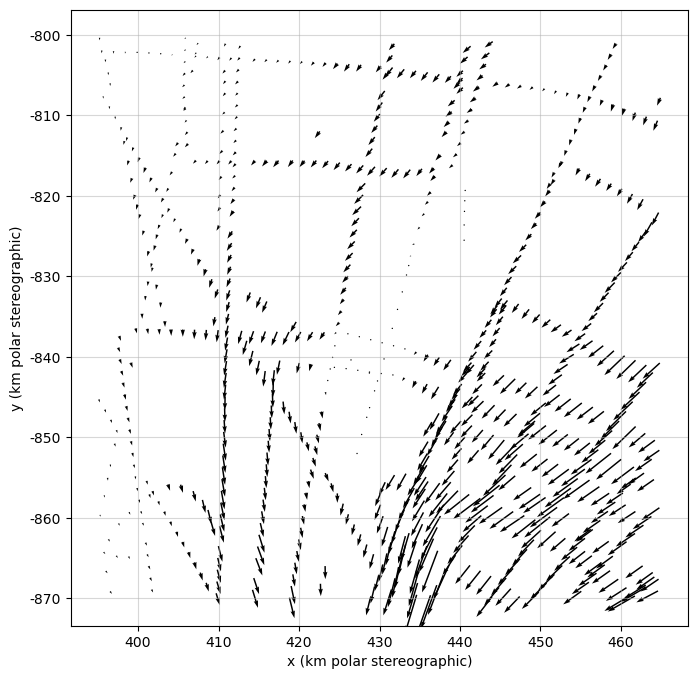

In [99]:
# Define region
region_name = "region_mid_byrd"

# Generate DataFrame
region_df = create_flux_df_for_region(
    region_name, thickness_points, velocity_grid, corners_regions, subsample_rate = 50)

# Remove NaN's if needed
# print(region_df.isna().sum())
# region_df = region_df.dropna()

# Visualise with color corresponing to survey/source
# visualise_flux(region_df, source_color = True)

# Remove very close points
removal_indices = find_very_close_points(region_df, threshold = 1200)

region_df_mindist = region_df.drop(removal_indices).reset_index(drop = True) # NOTE: reset indices is important

# Visualise
visualise_flux(region_df_mindist)

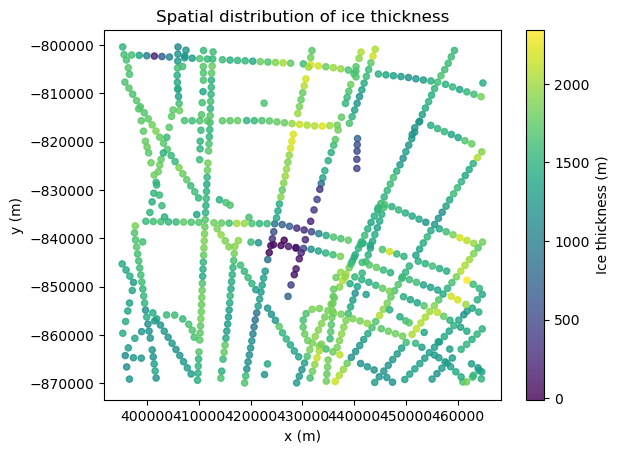

In [100]:
# Check to spot errors
sc = plt.scatter(
    region_df_mindist['x'], 
    region_df_mindist['y'], 
    c = region_df_mindist['t'], 
    s = 20.0, 
    alpha = 0.8, 
    cmap = 'viridis'
)

plt.colorbar(sc, label = 'Ice thickness (m)')  # Optional label
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("Spatial distribution of ice thickness")
plt.show()

## Mid Byrd train-test-split

The dataset contains 722 points.


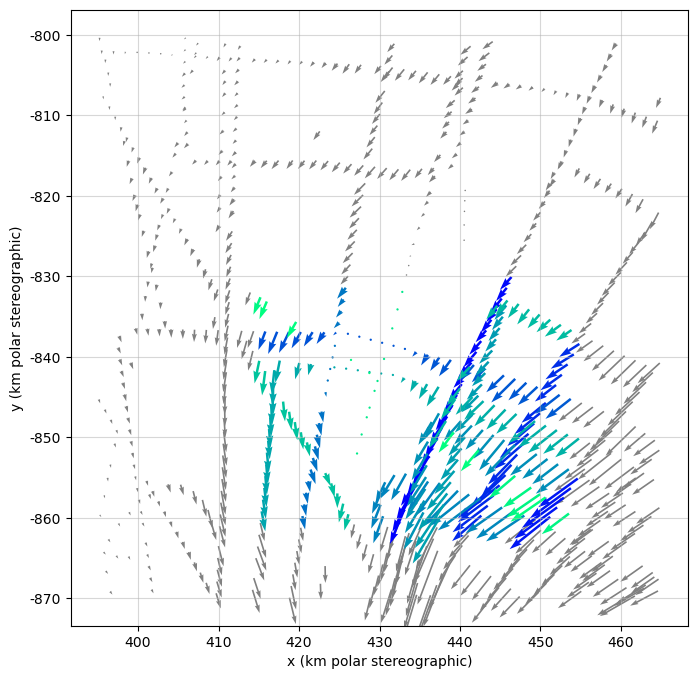

In [101]:
test_x_min = 415 * 1000
test_x_max = 455 * 1000
test_y_max = -830 * 1000
test_y_min = -860 * 1000
# 30 x 30 km gap - challenging for the model

test_indices = region_df_mindist[
        (region_df_mindist["x"] > test_x_min) & 
        (region_df_mindist["x"] < test_x_max) & 
        (region_df_mindist["y"] > test_y_min) & 
        (region_df_mindist["y"] < test_y_max)].index.tolist()

visualise_flux_train_test_split(region_df_mindist, test_indices, usecmap = "winter") # "turbo"

In [102]:
mid_meta = meta[meta["source"].isin(region_df_mindist["source"].unique())]
mid_meta

,source,BM_version,platform,firn,firn_correction,firn_correction_delta
0,BEDMAP1_1966-2000_AIR_BM1.csv,BM1,"airborne radar, gravity and seismic",-9999 (m),0.0,-10.0
14,BAS_2007_AGAP_AIR_BM2.csv,BM2,airborne radar.,10 (m),10.0,0.0
24,NASA_2011_ICEBRIDGE_AIR_BM2.csv,BM2,airborne radar.,0 (m),0.0,-10.0
97,NASA_2013_ICEBRIDGE_AIR_BM3.csv,BM3,airborne radar.,0 (m),0.0,-10.0
150,UTIG_2010_ICECAP_AIR_BM3.csv,BM3,airborne radar.,0 (m),0.0,-10.0


## Mid Byrd scaling 

In [103]:
print(region_df_mindist["xflux"].mean())
print(region_df_mindist["yflux"].mean())

region_flux_scale = 60 * 1000

-55960.57806936166
-85000.92053948085


In [104]:
# Get remaining train indices
all_indices = list(range(region_df_mindist.shape[0]))
print(f"The dataset contains {len(all_indices)} points.")
train_indices = list(set(all_indices) - set(test_indices))

# extract boundries of the region
x_min, x_max, y_min, y_max = corners_regions[corners_regions["name"] == region_name].loc[:, ["x_min", "x_max", "y_min", "y_max"]].values[0].tolist()

region_train_tensor = df_to_tensor(
    region_df_mindist.iloc[train_indices], x_min, x_max, y_min, y_max, region_flux_scale)
region_test_tensor = df_to_tensor(
    region_df_mindist.iloc[test_indices], x_min, x_max, y_min, y_max, region_flux_scale)

print(f"Train tensor shape: {region_train_tensor.shape}")
print(f"Test tensor shape: {region_test_tensor.shape}")

### STATS ###
# Compute mean and standard deviation along the samples (dim=1)
means_train = region_train_tensor.mean(dim = 1)
stds_train = region_train_tensor.std(dim = 1)

means_test = region_test_tensor.mean(dim = 1)
stds_test = region_test_tensor.std(dim = 1)

# Define column names
column_names = [
    "x",
    "y",
    "surface elevation (s)",
    "ice flux x (u)",
    "ice flux y (v)",
    "ice flux error x (u_err)",
    "ice flux error y (v_err)",
    "source age"
]

# Print neatly
print()
print("TRAIN Column Statistics (Mean ± Std):")
for i, name in enumerate(column_names):
    print(f"{name:25s}: {means_train[i]:.3f} ± {stds_train[i]:.3f}")

# Print neatly
print()
print("TEST Column Statistics (Mean ± Std):")
for i, name in enumerate(column_names):
    print(f"{name:25s}: {means_test[i]:.3f} ± {stds_test[i]:.3f}")

The dataset contains 722 points.
Train tensor shape: torch.Size([8, 501])
Test tensor shape: torch.Size([8, 221])

TRAIN Column Statistics (Mean ± Std):
x                        : 0.474 ± 0.324
y                        : 0.494 ± 0.335
surface elevation (s)    : 1.555 ± 0.183
ice flux x (u)           : -0.815 ± 1.008
ice flux y (v)           : -1.334 ± 1.057
ice flux error x (u_err) : 0.016 ± 0.008
ice flux error y (v_err) : 0.020 ± 0.010
source age               : 6.110 ± 1.474

TEST Column Statistics (Mean ± Std):
x                        : 0.583 ± 0.165
y                        : 0.332 ± 0.115
surface elevation (s)    : 1.449 ± 0.082
ice flux x (u)           : -1.199 ± 1.097
ice flux y (v)           : -1.604 ± 0.877
ice flux error x (u_err) : 0.015 ± 0.010
ice flux error y (v_err) : 0.019 ± 0.013
source age               : 5.991 ± 0.564


## Mid Byrd export

In [105]:
torch.save(region_train_tensor, f"data/real_data/{region_name}_train_tensor.pt")
torch.save(region_test_tensor, f"data/real_data/{region_name}_test_tensor.pt")

# Lower Byrd

- process by flight lines (throughout)
- smaller area

## Lower Byrd specs
- subsample_rate = 20
- threshold = 400 m
- region_flux_scale = 200 * 1000 m

Subsampled data shape: (1024, 18)
Minimum pairwise distance found among points in dataset (in m): 22.169
Number of rows to remove: 195
Rows to remove: {513, 618, 619, 563, 564, 569, 577, 578, 78, 79, 80, 597, 92, 609, 615, 616, 617, 106, 107, 108, 109, 110, 111, 623, 625, 622, 621, 620, 638, 639, 640, 142, 143, 144, 145, 146, 656, 660, 157, 158, 174, 686, 692, 702, 713, 727, 728, 730, 736, 739, 740, 745, 746, 753, 755, 756, 246, 247, 248, 760, 761, 766, 256, 265, 266, 778, 269, 270, 271, 272, 273, 274, 275, 789, 791, 792, 797, 286, 800, 808, 299, 811, 814, 815, 823, 312, 313, 314, 824, 834, 323, 836, 838, 839, 840, 334, 849, 851, 853, 855, 857, 859, 861, 863, 865, 867, 357, 358, 359, 871, 869, 873, 875, 365, 877, 879, 881, 883, 885, 886, 888, 890, 892, 382, 383, 384, 894, 896, 898, 900, 902, 391, 904, 906, 908, 910, 399, 911, 913, 915, 917, 919, 408, 409, 410, 411, 921, 923, 925, 927, 929, 931, 933, 935, 937, 939, 941, 942, 943, 945, 435, 947, 949, 951, 953, 955, 957, 959, 961, 963, 96

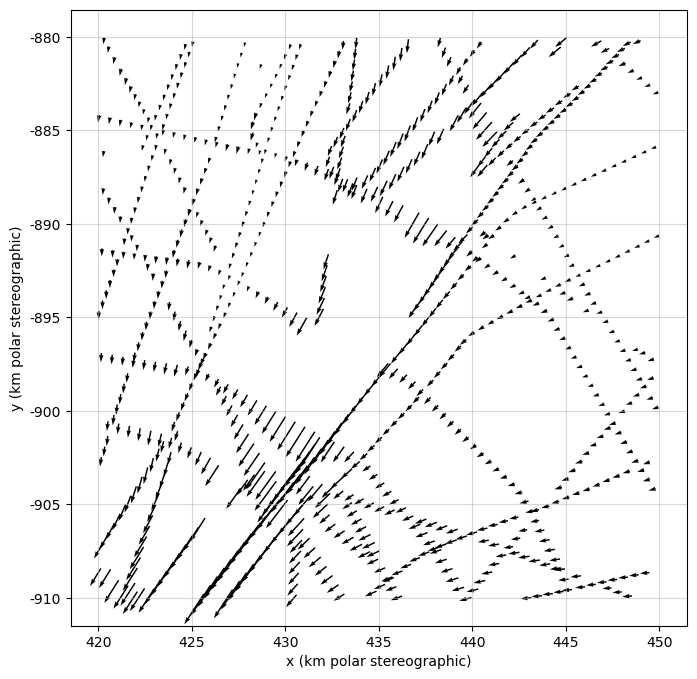

In [106]:
# Define region
region_name = "region_lower_byrd"

# Generate DataFrame
region_df = create_flux_df_for_region(
    region_name, thickness_points, velocity_grid, corners_regions, subsample_rate = 20)

# Remove NaN's if needed
# print(region_df.isna().sum())
# region_df = region_df.dropna()

# Visualise with color corresponing to survey/source
# visualise_flux(region_df, source_color = True)

# Remove very close points
removal_indices = find_very_close_points(region_df, threshold = 400)

region_df_mindist = region_df.drop(removal_indices).reset_index(drop = True) # NOTE: reset indices is important

# Visualise
visualise_flux(region_df_mindist)

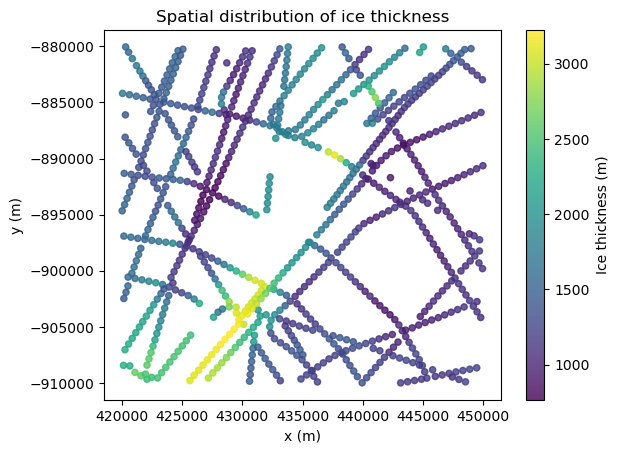

In [107]:
sc = plt.scatter(
    region_df_mindist['x'], 
    region_df_mindist['y'], 
    c = region_df_mindist['t'], 
    s = 20.0, 
    alpha = 0.8, 
    cmap = 'viridis'
)

plt.colorbar(sc, label = 'Ice thickness (m)')  # Optional label
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("Spatial distribution of ice thickness")
plt.show()

In [108]:
lower_meta = meta[meta["source"].isin(region_df_mindist["source"].unique())]
lower_meta

,source,BM_version,platform,firn,firn_correction,firn_correction_delta
0,BEDMAP1_1966-2000_AIR_BM1.csv,BM1,"airborne radar, gravity and seismic",-9999 (m),0.0,-10.0
14,BAS_2007_AGAP_AIR_BM2.csv,BM2,airborne radar.,10 (m),10.0,0.0
24,NASA_2011_ICEBRIDGE_AIR_BM2.csv,BM2,airborne radar.,0 (m),0.0,-10.0
97,NASA_2013_ICEBRIDGE_AIR_BM3.csv,BM3,airborne radar.,0 (m),0.0,-10.0
117,NASA_2017_ICEBRIDGE_AIR_BM3.csv,BM3,airborne radar.,0 (m),0.0,-10.0
150,UTIG_2010_ICECAP_AIR_BM3.csv,BM3,airborne radar.,0 (m),0.0,-10.0


## Lower Byrd train-test-split

The dataset contains 829 points.


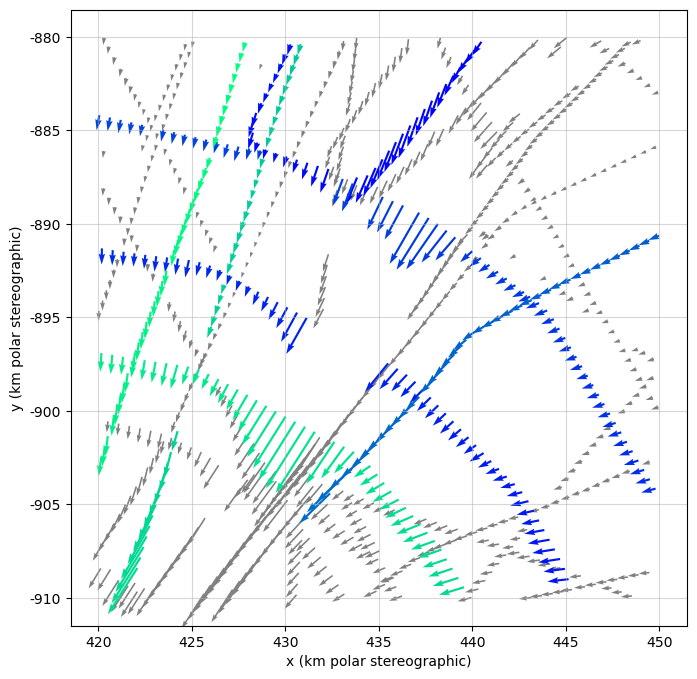

In [109]:
test_indices = list(list(range(114, 150)) # U at top
                    + list(range(158, 260)) # horizontal C shape
                    + list(range(298, 337)) # right line
                    + list(range(522, 638)) # vertical parallel to first line
                    )
        
visualise_flux_train_test_split(region_df_mindist, test_indices, usecmap = "winter") # "turbo" "winter"
# winter starts blue and gets green

## Lower Byrd scaling

In [110]:
print(region_df_mindist["xflux"].mean())
print(region_df_mindist["yflux"].mean())

region_flux_scale = 200 * 1000

-256592.8007000239
-329710.76051046536


In [111]:
# Get remaining train indices
all_indices = list(range(region_df_mindist.shape[0]))
print(f"The dataset contains {len(all_indices)} points.")
train_indices = list(set(all_indices) - set(test_indices))

# extract boundries of the region
x_min, x_max, y_min, y_max = corners_regions[corners_regions["name"] == region_name].loc[:, ["x_min", "x_max", "y_min", "y_max"]].values[0].tolist()

region_train_tensor = df_to_tensor(
    region_df_mindist.iloc[train_indices], x_min, x_max, y_min, y_max, region_flux_scale)
region_test_tensor = df_to_tensor(
    region_df_mindist.iloc[test_indices], x_min, x_max, y_min, y_max, region_flux_scale)

print(f"Train tensor shape: {region_train_tensor.shape}")
print(f"Test tensor shape: {region_test_tensor.shape}")

### STATS ###
# Compute mean and standard deviation along the samples (dim=1)
means_train = region_train_tensor.mean(dim = 1)
stds_train = region_train_tensor.std(dim = 1)

means_test = region_test_tensor.mean(dim = 1)
stds_test = region_test_tensor.std(dim = 1)

# Define column names
column_names = [
    "x",
    "y",
    "surface elevation (s)",
    "ice flux x (u)",
    "ice flux y (v)",
    "ice flux error x (u_err)",
    "ice flux error y (v_err)",
    "source age"
]

# Print neatly
print()
print("TRAIN Column Statistics (Mean ± Std):")
for i, name in enumerate(column_names):
    print(f"{name:25s}: {means_train[i]:.3f} ± {stds_train[i]:.3f}")

# Print neatly
print()
print("TEST Column Statistics (Mean ± Std):")
for i, name in enumerate(column_names):
    print(f"{name:25s}: {means_test[i]:.3f} ± {stds_test[i]:.3f}")

The dataset contains 829 points.
Train tensor shape: torch.Size([8, 536])
Test tensor shape: torch.Size([8, 293])

TRAIN Column Statistics (Mean ± Std):
x                        : 0.493 ± 0.291
y                        : 0.496 ± 0.327
surface elevation (s)    : 0.972 ± 0.148
ice flux x (u)           : -1.450 ± 1.001
ice flux y (v)           : -1.776 ± 1.437
ice flux error x (u_err) : 0.004 ± 0.002
ice flux error y (v_err) : 0.005 ± 0.002
source age               : 5.657 ± 2.963

TEST Column Statistics (Mean ± Std):
x                        : 0.430 ± 0.275
y                        : 0.526 ± 0.256
surface elevation (s)    : 0.981 ± 0.105
ice flux x (u)           : -0.978 ± 0.747
ice flux y (v)           : -1.415 ± 1.010
ice flux error x (u_err) : 0.003 ± 0.001
ice flux error y (v_err) : 0.004 ± 0.001
source age               : 6.000 ± 0.000


## Export Lower Byrd

In [112]:
torch.save(region_train_tensor, f"data/real_data/{region_name}_train_tensor.pt")
torch.save(region_test_tensor, f"data/real_data/{region_name}_test_tensor.pt")

# We define the coordinates of our experimental regions

- We write out the polar stereographic coordinates (EPSG:3031) for every square.
- We write the coordinates in kilometer units (* 1000) for easier readability.
- subsampling will still keep it approximately irregulaly spaced but off-grid